In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    LabelEncoder,
)

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score

import warnings

warnings.simplefilter("ignore")

In [2]:
db_train = pd.read_csv("../data/train.csv")
db_test = pd.read_csv("../data/holdout.csv")

In [3]:
db_train.head()

,row_id,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,...,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow
0,60284bd679027a1a,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,5af49400eeec47eb,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,367cbc10c57ff320,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,f9841359d0350bc8,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0
4,5f4d2848f7ee131a,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,W,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0


In [4]:
db_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_id         50000 non-null  object 
 1   mintemp        49702 non-null  float64
 2   maxtemp        49846 non-null  float64
 3   rainfall       49393 non-null  float64
 4   evaporation    24562 non-null  float64
 5   sunshine       20012 non-null  float64
 6   windgustdir    46107 non-null  object 
 7   windgustspeed  46111 non-null  float64
 8   winddir9am     45424 non-null  object 
 9   winddir3pm     48212 non-null  object 
 10  windspeed9am   49220 non-null  float64
 11  windspeed3pm   48772 non-null  float64
 12  humidity9am    49270 non-null  float64
 13  humidity3pm    48919 non-null  float64
 14  pressure9am    43207 non-null  float64
 15  pressure3pm    43235 non-null  float64
 16  cloud9am       30979 non-null  float64
 17  cloud3pm       30296 non-null  float64
 18  temp9a

In [5]:
db_train = db_train.replace({"Yes": 1, "No": 0})
db_test = db_test.replace({"Yes": 1, "No": 0})
db_train = db_train.drop(["row_id"], axis=1)
db_test = db_test.drop(["row_id"], axis=1)

In [6]:
numeric_cols = set(db_train.select_dtypes(include=np.number).columns)
categorical_cols = set(db_train.select_dtypes(include="object").columns)

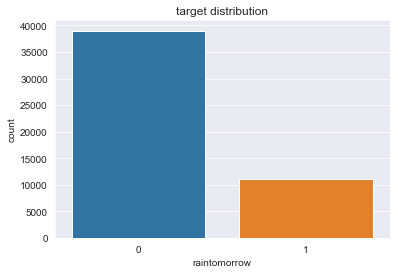

In [7]:
plt.title("target distribution")
sns.countplot(x=db_train["raintomorrow"])
plt.savefig("./plots/target_distribution.pdf")
plt.show()

In [8]:
db_train.describe()

,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow
count,49702.000000,49846.000000,49393.000000,24562.000000,20012.000000,46111.000000,49220.000000,48772.000000,49270.000000,48919.000000,43207.000000,43235.000000,30979.000000,30296.000000,49511.000000,49114.000000,49393.000000,50000.000000
mean,11.312474,22.313249,2.374618,5.280405,7.376164,40.049815,13.765888,18.455261,70.980292,52.015372,1018.313044,1015.906437,4.583976,4.684876,15.867537,20.867582,0.217622,0.219960
std,6.265056,6.905111,8.514221,4.128235,3.833537,14.315730,9.425962,9.369228,17.857184,20.681296,7.073780,6.958086,2.914586,2.695252,6.063108,6.721846,0.412633,0.414223
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,3.000000,1.000000,980.500000,979.000000,0.000000,0.000000,-7.000000,-5.100000,0.000000,0.000000
25%,6.800000,17.600000,0.000000,2.600000,4.500000,30.000000,7.000000,11.000000,59.000000,37.000000,1013.600000,1011.300000,1.000000,2.000000,11.600000,16.400000,0.000000,0.000000
50%,11.500000,21.900000,0.000000,4.400000,8.200000,39.000000,13.000000,17.000000,72.000000,52.000000,1018.400000,1016.000000,6.000000,5.000000,16.100000,20.400000,0.000000,0.000000
75%,16.200000,26.700000,0.600000,7.000000,10.400000,48.000000,19.000000,24.000000,85.000000,66.000000,1023.100000,1020.600000,7.000000,7.000000,20.400000,25.100000,0.000000,0.000000
max,31.900000,47.300000,371.000000,86.200000,14.500000,135.000000,130.000000,83.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.700000,46.700000,1.000000,1.000000


In [9]:
db_train.isnull().sum()

mintemp            298
maxtemp            154
rainfall           607
evaporation      25438
sunshine         29988
windgustdir       3893
windgustspeed     3889
winddir9am        4576
winddir3pm        1788
windspeed9am       780
windspeed3pm      1228
humidity9am        730
humidity3pm       1081
pressure9am       6793
pressure3pm       6765
cloud9am         19021
cloud3pm         19704
temp9am            489
temp3pm            886
raintoday          607
raintomorrow         0
dtype: int64

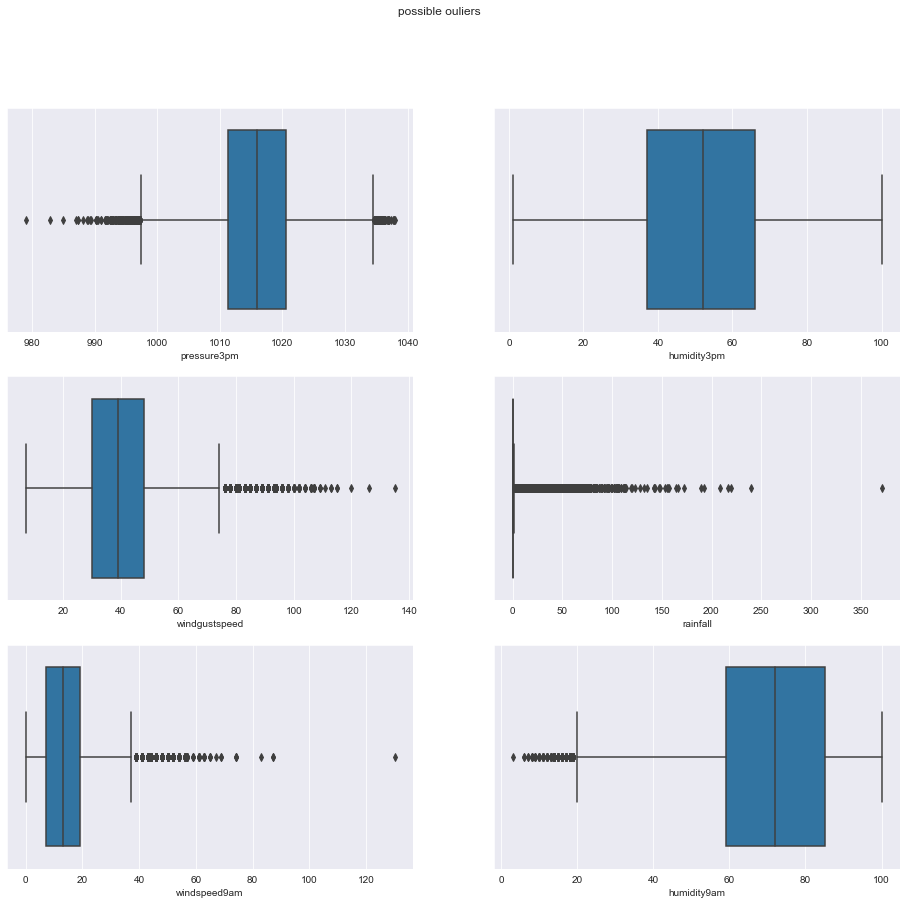

In [10]:
plt.figure(figsize=(16, 14))
plt.suptitle("possible ouliers")

plt.subplot(321)
sns.boxplot(x=db_train["pressure3pm"].dropna())

plt.subplot(322)
sns.boxplot(x=db_train["humidity3pm"].dropna())

plt.subplot(323)
sns.boxplot(x=db_train["windgustspeed"].dropna())

plt.subplot(324)
sns.boxplot(x=db_train["rainfall"].dropna())

plt.subplot(325)
sns.boxplot(x=db_train["windspeed9am"].dropna())

plt.subplot(326)
sns.boxplot(x=db_train["humidity9am"].dropna())

plt.savefig("./plots/possible_outliers.pdf")
plt.show()

In [11]:
db_train = db_train[db_train["windgustspeed"] <= 70]
db_train = db_train[db_train["windspeed9am"] <= 35]
db_train = db_train[db_train["humidity9am"] >= 25]
db_train = db_train[
    (db_train["pressure3pm"] >= 1000) & (db_train["pressure3pm"] <= 1030)
]

In [12]:
def prepare_data(
    df: pd.DataFrame,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    encoder=LabelEncoder(),
    only_num=True,
) -> pd.DataFrame:

    for column in df.columns:
        if column in numeric_cols:
            df[column] = df[column].fillna(np.median(df[column].dropna()))
        elif column in categorical_cols:
            df[column] = df[column].fillna("unknown")
            df[column] = encoder.fit_transform(df[column])

    if only_num:
        return df[numeric_cols]
    return df

In [13]:
x_train = prepare_data(db_train, only_num=False)
x_test = prepare_data(db_test, only_num=False)

y_train = x_train["raintomorrow"]
x_train = x_train.drop(["raintomorrow"], axis=1)

y_test = x_test["raintomorrow"]
x_test = x_test.drop(["raintomorrow"], axis=1)

numeric_cols.remove("raintomorrow")

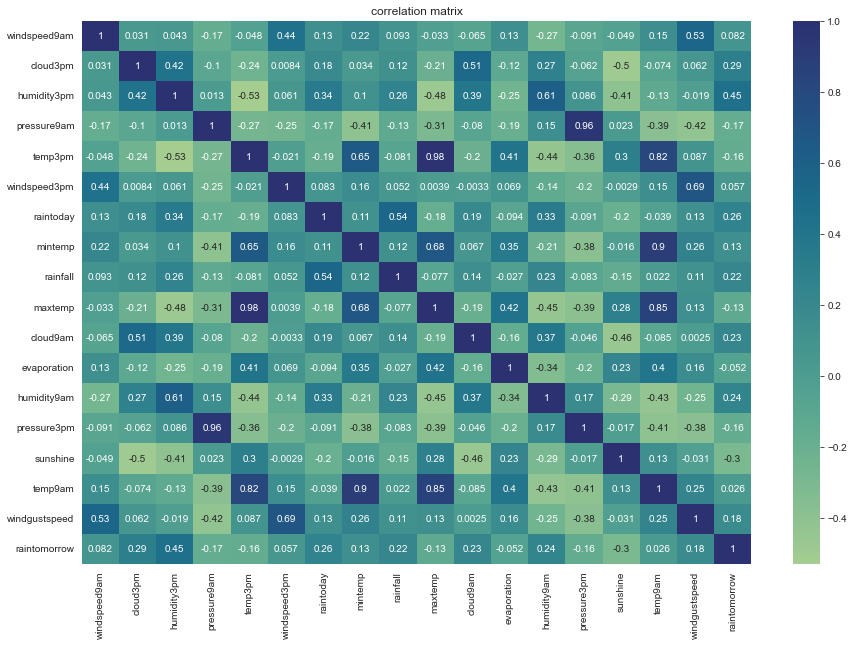

In [14]:
correlations = pd.concat((x_train[numeric_cols], y_train), axis=1).corr()
plt.figure(figsize=(15, 10))
plt.title("correlation matrix")
sns.heatmap(correlations, annot=True, cmap="crest")
plt.savefig("./plots/correlation_matrix.pdf")
plt.show()

In [15]:
print(f"total nans: {x_train.isnull().sum().sum()}")

total nans: 0


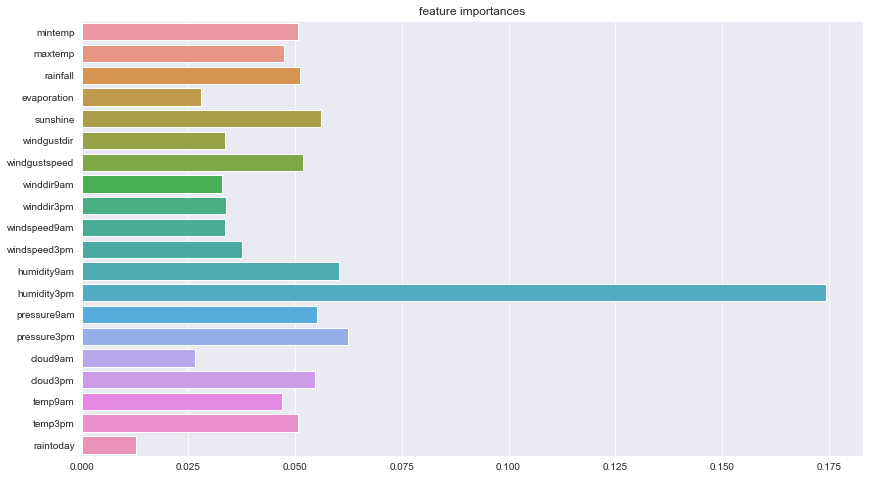

In [16]:
selector = RandomForestClassifier(n_jobs=-1)
selector.fit(x_train, y_train)
feature_importances = selector.feature_importances_

plt.figure(figsize=(14, 8))
plt.title("feature importances")

features = x_train.columns

sns.barplot(y=features, x=feature_importances)
plt.savefig("./plots/feature_importances.pdf")
plt.show()

In [17]:
scaler = StandardScaler()
x_train[list(numeric_cols)] = scaler.fit_transform(x_train[list(numeric_cols)])
x_test[list(numeric_cols)] = scaler.transform(x_test[list(numeric_cols)])

transformer = PolynomialFeatures()
poly_x_train = transformer.fit_transform(x_train[list(numeric_cols)])
poly_x_test = transformer.transform(x_test[list(numeric_cols)])

In [18]:
lr = LogisticRegression()
lr.fit(poly_x_train, y_train)
y_pred = lr.predict_proba(poly_x_test)[:, 1]
print(f"ROC-AUC (default LR): {roc_auc_score(y_test, y_pred):.4f}")

knn = KNeighborsClassifier()
knn.fit(poly_x_train, y_train)
y_pred = knn.predict_proba(poly_x_test)[:, 1]
print(f"ROC-AUC (default KNN): {roc_auc_score(y_test, y_pred):.4f}")

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict_proba(x_test)[:, 1]
print(f"ROC-AUC (default RF): {roc_auc_score(y_test, y_pred):.4f}")

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred = dt.predict_proba(x_test)[:, 1]
print(f"ROC-AUC (default DT): {roc_auc_score(y_test, y_pred):.4f}")

ROC-AUC (default LR): 0.8680
ROC-AUC (default KNN): 0.7750
ROC-AUC (default RF): 0.8591
ROC-AUC (default DT): 0.6528


In [19]:
knn = KNeighborsClassifier()
knn_grid = {
    "n_neighbors": [1, 5, 7, 15, 30, 50, 70, 100],
    "metric": ["cosine", "euclidean", "minkowski"],
}

knn_grid_searcher = GridSearchCV(knn, knn_grid, cv=3, scoring="roc_auc")
knn_grid_searcher.fit(poly_x_train, y_train)
print(f"Best parameters: {knn_grid_searcher.best_params_}")
print(f"Best score: {knn_grid_searcher.best_score_:.4f}")

Best parameters: {'metric': 'cosine', 'n_neighbors': 70}
Best score: 0.8357


In [20]:
lr = LogisticRegression(max_iter=1000)
lr_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 50, 100],
    "solver": ["newton-cg", "lbfgs", "liblinear"],
    "penalty": [None, "l1", "l2"],
    "class_weight": [None, "balanced"],
}

lr_grid_searcher = GridSearchCV(
    lr, lr_grid, cv=3, scoring="roc_auc", n_jobs=-1
)
lr_grid_searcher.fit(poly_x_train, y_train)
print(f"Best parameters: {lr_grid_searcher.best_params_}")
print(f"Best score: {lr_grid_searcher.best_score_:.4f}")

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.8543


In [21]:
rf = RandomForestClassifier(n_jobs=-1)
rf_grid = {
    "bootstrap": [False, True],
    "max_depth": [10, 20, 30],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [1000, 1400, 1800],
}

rf_grid_searcher = GridSearchCV(
    rf, rf_grid, cv=3, scoring="roc_auc", n_jobs=-1
)
rf_grid_searcher.fit(x_train, y_train)
print(f"Best parameters: {rf_grid_searcher.best_params_}")
print(f"Best score: {rf_grid_searcher.best_score_:.4f}")

Best parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1800}
Best score: 0.8561


In [22]:
best_lr = lr_grid_searcher.best_estimator_
lr_y_pred = best_lr.predict_proba(poly_x_test)[:, 1]
print(f"ROC-AUC (tuned LR): {roc_auc_score(y_test, lr_y_pred):.4f}")

best_knn = knn_grid_searcher.best_estimator_
knn_y_pred = best_knn.predict_proba(poly_x_test)[:, 1]
print(f"ROC-AUC (tuned KNN): {roc_auc_score(y_test, knn_y_pred):.4f}")

best_rf = rf_grid_searcher.best_estimator_
rf_y_pred = best_rf.predict_proba(x_test)[:, 1]
print(f"ROC-AUC (tuned RF): {roc_auc_score(y_test, rf_y_pred):.4f}")

ROC-AUC (tuned LR): 0.8678
ROC-AUC (tuned KNN): 0.8445
ROC-AUC (tuned RF): 0.8666


In [23]:
class Blending:
    """
    Blend 2 models with specified weights.
    """

    def __init__(self, m1=best_lr, m2=best_rf, weights=[1, 1]) -> None:
        self.m1 = m1
        self.m2 = m2
        self.weights = weights

    def fit(self, x: np.array, x_poly: np.array, y: np.array) -> None:
        self.m1.fit(x_poly, y)
        self.m2.fit(x, y)

    def predict(self, x: np.array, x_poly: np.array) -> np.array:
        m1_pred = self.m1.predict(x_poly)
        m2_pred = self.m2.predict(x)
        return (m1_pred * self.weights[0] + m2_pred * self.weights[1]) / 2

    def predict_proba(self, x: np.array, x_poly: np.array) -> np.array:
        m1_pred = self.m1.predict_proba(x_poly)[:, 1]
        m2_pred = self.m2.predict_proba(x)[:, 1]
        return (m1_pred * self.weights[0] + m2_pred * self.weights[1]) / 2

In [24]:
final_model = Blending()
final_model.fit(x_train, poly_x_train, y_train)
y_pred = final_model.predict_proba(x_test, poly_x_test)
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.4f}")

ROC-AUC: 0.8732
